In [1]:
import random
import numpy as np
import pandas as pd
import cvxpy as cp
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms


In [2]:
"""
Data Load
"""
cov_matrix = pd.read_excel("沪深300十年收盘价相关系数.xlsx", index_col=0)
cov_matrix

,000001.SZ,000002.SZ,000063.SZ,000069.SZ,000100.SZ,000157.SZ,000301.SZ,000338.SZ,000408.SZ,000425.SZ,...,601888.SH,601898.SH,601899.SH,601901.SH,601919.SH,601939.SH,601988.SH,601989.SH,601998.SH,603993.SH
000001.SZ,1.000,0.456,0.331,0.460,0.343,0.409,0.226,0.316,0.154,0.265,...,0.276,0.361,0.302,0.456,0.285,0.565,0.505,0.290,0.559,0.262
000002.SZ,0.456,1.000,0.286,0.593,0.263,0.378,0.183,0.309,0.110,0.247,...,0.223,0.295,0.257,0.348,0.241,0.444,0.377,0.244,0.395,0.215
000063.SZ,0.331,0.286,1.000,0.354,0.473,0.380,0.307,0.330,0.283,0.304,...,0.285,0.287,0.290,0.390,0.306,0.258,0.237,0.388,0.271,0.303
000069.SZ,0.460,0.593,0.354,1.000,0.360,0.478,0.325,0.385,0.250,0.344,...,0.271,0.444,0.364,0.444,0.341,0.416,0.386,0.406,0.405,0.304
000100.SZ,0.343,0.263,0.473,0.360,1.000,0.487,0.343,0.388,0.275,0.320,...,0.289,0.378,0.384,0.439,0.343,0.278,0.245,0.403,0.263,0.340
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
601939.SH,0.565,0.444,0.258,0.416,0.278,0.371,0.171,0.285,0.075,0.240,...,0.197,0.387,0.293,0.427,0.254,1.000,0.769,0.301,0.658,0.217
601988.SH,0.505,0.377,0.237,0.386,0.245,0.298,0.168,0.244,0.074,0.212,...,0.166,0.368,0.242,0.408,0.234,0.769,1.000,0.257,0.692,0.192
601989.SH,0.290,0.244,0.388,0.406,0.403,0.482,0.370,0.394,0.328,0.346,...,0.253,0.478,0.369,0.437,0.400,0.301,0.257,1.000,0.288,0.356
601998.SH,0.559,0.395,0.271,0.405,0.263,0.339,0.199,0.280,0.128,0.256,...,0.199,0.367,0.266,0.457,0.251,0.658,0.692,0.288,1.000,0.217


In [3]:
"""
Check Matrix Symmetry
"""
def check_symmetry(cov_matrix):
    # Check symmetry
    if not np.allclose(cov_matrix, cov_matrix.T):
        print("The covariance matrix is not symmetric.")
    else:
        print("The covariance matrix is symmetric.")
        return

    # Find non-symmetric pairs
    non_symmetric_pairs = []
    for i in range(len(cov_matrix)):
        for j in range(i+1, len(cov_matrix)):
            if not np.isclose(cov_matrix.iloc[i, j], cov_matrix.iloc[j, i]):
                row_asset = cov_matrix.index[i]
                col_asset = cov_matrix.columns[j]
                non_symmetric_pairs.append((row_asset, col_asset))
    for pair in non_symmetric_pairs:
        print("Non-symmetric pair:", pair)

# check_symmetry(cov_matrix)

In [4]:
"""
GA Initialization
"""
# Objective
creator.create("FitnessMulti", base.Fitness, weights=(-1.0,)) # MIN portfolio variance
creator.create("Individual", list, fitness=creator.FitnessMulti)

# Individual Initialisation
toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=len(cov_matrix.columns))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [5]:
"""
Test Model:
Min sum(wi*cov(ri,rj)), s.t. sum(wi)=1，0<=wi<=1
"""
# Portfolio Variance
def test_model(individual, cov_matrix):
    # extract sub matrix
    included_assets_indices = [index for index, include in enumerate(individual) if include == 1]
    sub_cov_matrix = cov_matrix.iloc[included_assets_indices, included_assets_indices]
    sub_cov_matrix = np.array(sub_cov_matrix)

    # bound and weight
    n = len(included_assets_indices)
    bounds_min = [0 for _ in range(n)]
    bounds_max = [1 for _ in range(n)]
    weights = cp.Variable(n)

    # define objective - minimize variance
    portfolio_variance = cp.quad_form(weights, sub_cov_matrix)
    objective = cp.Minimize(portfolio_variance)

    # constraints
    constraints = [cp.sum(weights) == 1, weights >= bounds_min, weights <= bounds_max]
    problem = cp.Problem(objective, constraints)

    # solve problem
    problem.solve()
    if problem.status == cp.OPTIMAL:
        optimal_weights = weights.value
        optimal_portfolio_variance = np.dot(optimal_weights.T, np.dot(sub_cov_matrix, optimal_weights))
    else:
        optimal_weights = None
        optimal_portfolio_variance = 9999

    return optimal_portfolio_variance, optimal_weights

In [6]:
"""
Fitness Function
"""
def evaluate(individual):
    portfolio_variance, weights = test_model(individual, cov_matrix)
    return portfolio_variance,

In [7]:
"""
Algorithm Setup
"""
toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selNSGA2)

In [8]:
"""
Run GA
"""
def run_ga(pop_size, num_generations):
    pop = toolbox.population(n=pop_size)
    hof = tools.ParetoFront()
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean, axis=0)
    stats.register("std", np.std, axis=0)
    stats.register("min", np.min, axis=0)
    stats.register("max", np.max, axis=0)

    # check hof generation number (1)
    # generation_of_individual = {}
    # for gen in range(num_generations):
    #     # Check generation index
    #     print(f"Generation: {gen}")
    #     # Run one generation of the genetic algorithm
    #     algorithms.eaSimple(pop, toolbox, cxpb=0.7, mutpb=0.2, ngen=1, stats=stats, halloffame=hof, verbose=True)
    #     # Update the generation information for each individual in the hall of fame
    #     for ind in hof:
    #         if str(ind) not in generation_of_individual:
    #             generation_of_individual[str(ind)] = gen
    # return pop, hof, stats, generation_of_individual

    # without generation series check (2)
    pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=0.7, mutpb=0.2, ngen=num_generations, stats=stats, halloffame=hof, verbose=True)

    return pop, hof, stats, logbook

population, pareto_front, stats, logbook = run_ga(500, 1000)

gen	nevals	avg        	std         	min         	max         
0  	500   	[0.1915306]	[0.00860538]	[0.17061813]	[0.22359447]
1  	365   	[0.19173733]	[0.00923205]	[0.16923911]	[0.2284296] 
2  	392   	[0.19190298]	[0.00981169]	[0.17075928]	[0.23245345]
3  	358   	[0.19199887]	[0.01040521]	[0.17075928]	[0.23245345]
4  	366   	[0.19206817]	[0.01107408]	[0.16948981]	[0.23245345]
5  	358   	[0.19201305]	[0.01142657]	[0.16948981]	[0.22456781]
6  	388   	[0.19196831]	[0.01199344]	[0.16953981]	[0.24049162]
7  	381   	[0.19205821]	[0.01234437]	[0.16955637]	[0.23570263]
8  	389   	[0.19213447]	[0.01271241]	[0.16859849]	[0.23650732]
9  	376   	[0.19230859]	[0.01297004]	[0.16897038]	[0.23589064]
10 	386   	[0.19238018]	[0.0132897] 	[0.16885223]	[0.23716392]
11 	383   	[0.19246372]	[0.0135336] 	[0.16881156]	[0.23386663]
12 	393   	[0.19242103]	[0.01388974]	[0.16881156]	[0.23386663]
13 	413   	[0.19236874]	[0.01384681]	[0.16881156]	[0.23385126]
14 	379   	[0.19221388]	[0.01401377]	[0.16875074]	[0.2345

In [9]:
"""
Pareto Front Output
"""
# Get weights info
def get_weights(individual):
    portfolio_variance, optimized_weights = test_model(individual, cov_matrix)
    full_weights = np.zeros(len(cov_matrix.columns))
    weight_index = 0
    for i, included in enumerate(individual):
        if included == 1:
            full_weights[i] = optimized_weights[weight_index]
            weight_index += 1
    return full_weights

# Retrieve and store weights
individual_weights = {str(ind): get_weights(ind) for ind in pareto_front}

# Print the individuals, corresponding weights and generation series number
for ind in pareto_front:
    print(f"Individual: {ind}")
    print(f"Weights: {individual_weights[str(ind)]}")
    print(f"Portfolio Variance: {test_model(ind, cov_matrix)[0]}")
    # print(f"Generation Index: {generation_of_individual[str(ind)]}")


Individual: [0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0]
Weights: [ 0.00000000e+00  9.90306845e-03  0.00000000e+00  1.83386220e-24
  0.00000000e+00 -3.05849456e-22  0.00000000e+00  0.00000000e+00
  6.60947937e-03  0.00000000e+00 -1.58042126e-23 -2.97272674e-23
  0.00000000e+00 -2.60470999e-23  0.00000000e+00  2.86189014e-03
  1.12136933e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.16439599e-02  5.05353467e-02
  0

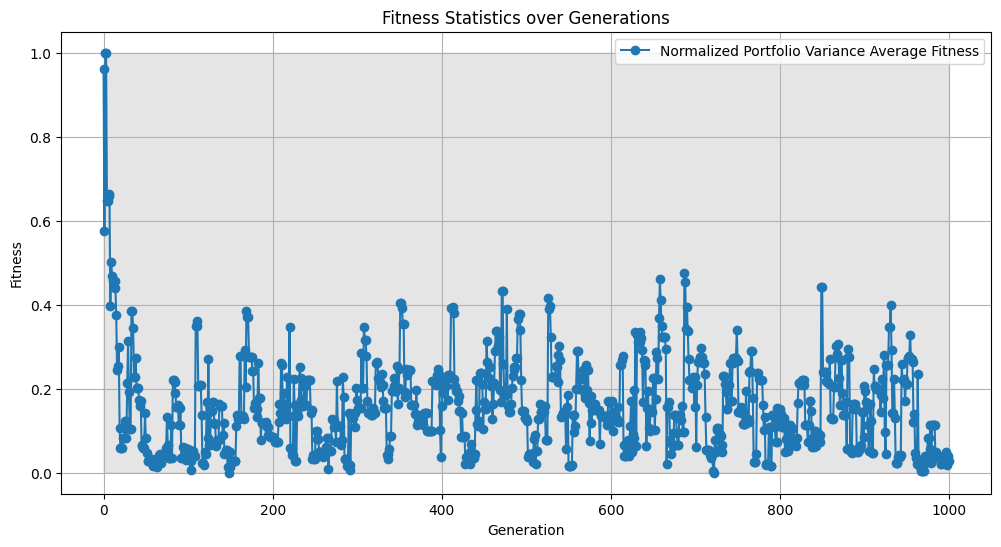

In [10]:
gen = logbook.select('gen')
min_fitness = logbook.select('min')

def normalize(data):
    min_val = np.min(data)
    max_val = np.max(data)
    return (data - min_val) / (max_val - min_val)

normalized_min_fitness = [normalize([fit[i] for fit in min_fitness]) for i in range(len(min_fitness[0]))]

plt.figure(figsize=(12, 6))

for obj_avg in normalized_min_fitness:
    plt.plot(gen, obj_avg, label=f'Normalized Portfolio Variance Average Fitness', marker='o')

plt.fill_between(gen, 0, 1, alpha=0.2, color='grey')

plt.title('Fitness Statistics over Generations')
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.legend()
plt.grid(True)
plt.show()